In [1]:
import logging
import sys
from typing import Dict, List, Iterable, Tuple, Union
import warnings
warnings.filterwarnings('ignore')

import leabra7 as lb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
LoggerType = Union[None, logging.Logger, logging.LoggerAdapter]

In [3]:
def load_data() -> Tuple[np.ndarray, np.ndarray]:
    """
    Loads and preprocesses the data.
    
    Returns:
        An (X, Y) tuple containing the features and labels, respectively.
    """
    X = np.array([
        [1, 0, 1, 0],
        [0, 1, 0, 1],
        [1, 1, 0, 0],
        [0, 0, 1, 1,],
    ])
    Y = np.array([
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
    ])
    return (X, Y)

def build_network(logger: LoggerType = None) -> lb.Net:
    """
    Builds the classifier network.
    
    Args:
        logger: The logger to use.
    
    Returns:
        A Leabra7 network for classification.
    """
    if logger is None:
        logger = logging.getLogger()
    logger.info("Building network")
    net = lb.Net()
    
    # Layers
    layer_spec = lb.LayerSpec(
        gi=1.5,
        fb=1,
        ff=1,
        unit_spec=lb.UnitSpec(
            adapt_dt=0,
            vm_gain=0,
            spike_gain=0,
            ss_dt=1,
            s_dt=0.2,
            m_dt=0.1,
            l_dn_dt=0.4,
            l_up_inc=0.15,
            vm_dt=1 / 3.3,
            net_dt=0.7))
    
    net.new_layer("input", size=4, spec=layer_spec)
    net.new_layer("hidden", size=4, spec=layer_spec)
    net.new_layer("output", size=2, spec=layer_spec)
    
    # Projections
    lrate = 0.02
    up_spec = lb.ProjnSpec(
        lrate=lrate,
        dist=lb.Uniform(0.25, 0.75),
        thr_l_mix=0,
        cos_diff_lrate=False,
        cos_diff_thr_l_mix=True)
    down_spec = lb.ProjnSpec(
        lrate=lrate,
        dist=lb.Uniform(0.25, 0.75),
        wt_scale_rel=0.3,
        thr_l_mix=0,
        cos_diff_lrate=False,
        cos_diff_thr_l_mix=True)
    
    net.new_projn(
        "input_to_hidden", pre="input", post="hidden", spec=up_spec)
    net.new_projn(
        "hidden_to_output", pre="hidden", post="output", spec=up_spec)
    net.new_projn(
        "output_to_hidden", pre="output", post="hidden", spec=down_spec)
    
    return net

def trial(network: lb.Net, input_pattern: Iterable[float],
          output_pattern: Iterable[float]) -> None:
    """
    Runs a trial.
    
    Args:
        input_pattern: The pattern to clamp to the network's input layer.
        output_pattern: The pattern to clamp to the network's output layer.
    """
    network.clamp_layer("input", input_pattern)
    network.minus_phase_cycle(num_cycles=50)
    network.clamp_layer("output", output_pattern)
    network.plus_phase_cycle(num_cycles=20)
    network.unclamp_layer("input")
    network.unclamp_layer("output")
    network.learn()
    
def epoch(network: lb.Net, input_patterns: np.ndarray,
          output_patterns: np.ndarray) -> None:
    """
    Runs an epoch (one pass through the whole dataset).
    
    Args:
        input_patterns: A numpy array with shape (n_samples, n_features).
        output_patterns: A numpy array with shape (n_samples, n_features).
    """
    for x, y in zip(input_patterns, output_patterns):
        trial(network, x, y)
    network.end_epoch()
    
def mse_thresh(expected: np.ndarray,
               actual: np.ndarray,
               threshold: float = 0.1) -> float:
    """
    Calculates the thresholded mean squared error.
    If the error is < 0.5, it is treated as 0 (i.e., we count < 0.5 as 0 and
    > 0.5 as 1).
    
    Args:
        expected: The expected output pattern.
        actual: The actual output pattern
    
    Returns:
        The thresholded mean squared error.
    """
    diff = np.abs(expected - actual)
    diff[diff < threshold] = 0
    return np.mean(diff * diff)

def train(network: lb.Net,
          input_patterns: np.ndarray,
          output_patterns: np.ndarray,
          num_epochs: int = 3000,
          patience_perfect_epochs: int = 5,
          logger: LoggerType = None) -> pd.DataFrame:
    """
    Trains the network.
    
    Args:
        24input_patterns: A numpy array with shape (n_samples, n_features).
        output_patterns: A numpy array with shape (n_samples, n_features).
        num_patterns: The number of epochs to run. Defaults to 500.
        logger: The logger to use. If None, will use the module's default logger.
    
    Returns:
        pd.DataFrame: A dataframe of metrics from the training run.
    """
    if logger is None:
        logger = logging.getLogger()
    logger.info("Begin training")
    
    data: Dict[str, List[float]] = {
        "epoch": [],
        "train_loss": [],
        "train_acc": [],
    }
        
    perfect_epochs = 0
    for i in range(1, num_epochs + 1):
        epoch(network, input_patterns, output_patterns)
        pred = predict(network, input_patterns)
        data["epoch"].append(i)
        train_loss = mse_thresh(output_patterns, pred)
        data["train_loss"].append(train_loss)
        train_acc = (output_patterns == (pred > 0.5)).mean()
        data["train_acc"].append(train_acc)
        
        logger.info(f"[Epoch {i}/{num_epochs}]  Train loss: {train_loss:.6f}  " +\
                    f"Train acc: {train_acc:.2f}")
        if train_loss == 0:
            perfect_epochs += 1
        else:
            perfect_epochs = 0
        if perfect_epochs == patience_perfect_epochs:
            logger.info("Ending training after %d perfect epochs.",
                        perfect_epochs)
            break
            
    return pd.DataFrame(data)

def output(network: lb.Net, pattern: Iterable[float]) -> List[float]:
    """
    Calculates a prediction for a single input pattern.
    
    Args:
        network: The trained network.
        pattern: The input pattern.
    
    Returns:
        np.ndarray: The output of the network after clamping the input
        pattern to the input layer and settling. The max value is set to one,
        everything else is set to zero.
    """
    network.clamp_layer("input", pattern)
    for _ in range(50):
        network.cycle()
    network.unclamp_layer("input")
    out = network.observe("output", "unit_act")["act"].values
    return list(out)

def predict(network: lb.Net, input_patterns: np.ndarray) -> np.ndarray:
    """
    Calculates predictions for an array of input patterns.
    
    Args:
        network: The trained network.
        input_patterns: An array of shape (n_samples, n_features)
        containing the input patterns for which to calculate predictions.
    
    Returns:
        np.ndarray: An array of shape (n_samples, n_features) containing the
        predictions for the input patterns.
    """
    outputs = [output(network, item)
               for item in input_patterns]
    return np.array(outputs)

In [4]:
PROJ_NAME = "err_hidden"
logging.basicConfig(
    level=logging.DEBUG,
    format="%(levelname)s %(message)s",
    handlers=(
        logging.FileHandler(
            "{0}_log.txt".format(PROJ_NAME), mode="w"),
        logging.StreamHandler(sys.stdout)))

logging.info("Begin training %s", PROJ_NAME)

INFO Begin training err_hidden


In [5]:
X, Y = load_data()
net = build_network()
metrics = train(net, X, Y, num_epochs=3000)

# Save metrics and network for future analysis
metrics.to_csv("{0}_metrics.csv".format(PROJ_NAME), index=False)
net.save("{0}_network.pkl".format(PROJ_NAME))

INFO Building network
INFO Begin training
INFO [Epoch 1/3000]  Train loss: 0.389604  Train acc: 0.50
INFO [Epoch 2/3000]  Train loss: 0.387851  Train acc: 0.50
INFO [Epoch 3/3000]  Train loss: 0.386145  Train acc: 0.50
INFO [Epoch 4/3000]  Train loss: 0.384494  Train acc: 0.50
INFO [Epoch 5/3000]  Train loss: 0.382904  Train acc: 0.50
INFO [Epoch 6/3000]  Train loss: 0.382855  Train acc: 0.50
INFO [Epoch 7/3000]  Train loss: 0.381872  Train acc: 0.50
INFO [Epoch 8/3000]  Train loss: 0.380505  Train acc: 0.50
INFO [Epoch 9/3000]  Train loss: 0.379139  Train acc: 0.50
INFO [Epoch 10/3000]  Train loss: 0.377831  Train acc: 0.50
INFO [Epoch 11/3000]  Train loss: 0.376589  Train acc: 0.50
INFO [Epoch 12/3000]  Train loss: 0.375411  Train acc: 0.50
INFO [Epoch 13/3000]  Train loss: 0.374284  Train acc: 0.50
INFO [Epoch 14/3000]  Train loss: 0.373210  Train acc: 0.50
INFO [Epoch 15/3000]  Train loss: 0.372177  Train acc: 0.50
INFO [Epoch 16/3000]  Train loss: 0.371182  Train acc: 0.50
INFO [E

In [6]:
predict(net, X)

array([[0.6182043 , 0.64996445],
       [0.75130659, 0.2705445 ],
       [0.25416857, 0.76524198],
       [0.63415438, 0.61567414]])

In [7]:
Y

array([[1, 0],
       [1, 0],
       [0, 1],
       [0, 1]])

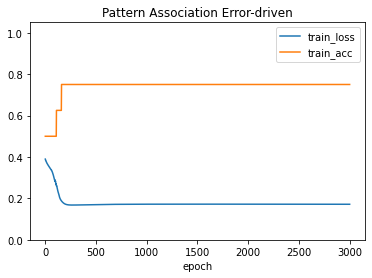

In [9]:
pd.read_csv('err_hidden_metrics.csv').plot(x='epoch');
plt.title("Pattern Association Error-driven");
plt.ylim((0,1.05))
plt.savefig("error_driven.png", dpi=300);